In [1]:
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
import tensorflow as tf
import keras
import tensorflow_probability as tfp
import matplotlib.pyplot as plt


2024-06-18 11:58:14.812282: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 11:58:14.856818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 11:58:14.856849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 11:58:14.857987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 11:58:14.865622: I tensorflow/core/platform/cpu_feature_guar

In [2]:
    # Distribution Settings
    scale = 1
    mean = 0

    normal_dist = scipy.stats.norm(loc=mean, scale=scale)

    # Number of independent datapoints 
    T = 1000

    seed=360
    rng = np.random.RandomState(seed)
    y_T = normal_dist.rvs(size=T, random_state=rng)

    # create keras model
    inputs = keras.Input(shape=0)
    # a dense layer with an empty input will just be an intercept term
    intercept_layer = keras.layers.Dense(1, activation = None)
    # Create a normal distribution with a mean equal to the input 
    distribution_layer = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))
    predicted_mean = intercept_layer(inputs)
    distribution = distribution_layer(predicted_mean)
    model = keras.Model(inputs=inputs, outputs=distribution)

2024-06-18 11:58:24.390454: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-18 11:58:24.390495: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-06-18 11:58:24.390502: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-06-18 11:58:24.390597: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-06-18 11:58:24.390624: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-06-18 11:58:24.390629: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [3]:
# Create an empty input so we can do a forward pass
x_TF = np.zeros(shape=(T,0))


In [4]:
# make a dataset and batch y_T and x_TF 
dataset = tf.data.Dataset.from_tensor_slices((x_TF, y_T))
dataset = dataset.batch(1)

In [8]:
for c, (x, y) in enumerate(dataset):
    1+1

In [9]:
c

999

In [5]:
M=1000

In [26]:
grads = []
vals = []
for val in np.linspace(-10,10,11):
    print(val)
    intercept = model.trainable_variables[1]
    intercept.assign([val])

    grad = 0
    for c, (x_F, y) in enumerate(dataset):
        print(c)
        with tf.GradientTape() as tape, tf.GradientTape() as loss_tape: 
            model_distribution = model(x_F)
            sample_y_M = model_distribution.sample(M)
            stopped_samples_M = tf.stop_gradient(sample_y_M)
            sample_log_probs_M = model_distribution.log_prob(stopped_samples_M)
            
            sample_action_M = model_distribution.sample(M)
            expected_action = tf.reduce_mean(sample_action_M, axis=0)
            loss = keras.losses.mean_squared_error(y, expected_action)
        action_grad_M = tape.jacobian(sample_log_probs_M, model.trainable_variables)
        loss_grad = loss_tape.gradient(loss, expected_action)
        grad += tf.reduce_mean(action_grad_M[1]*stopped_samples_M) * loss_grad
    grads.append(grad.numpy())
    vals.append(val)

-10.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


KeyboardInterrupt: 

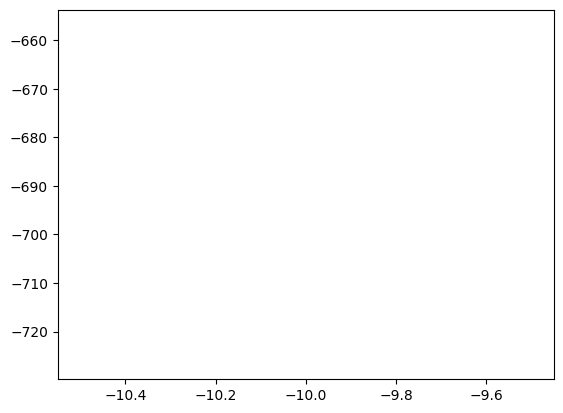

In [27]:
plt.plot(vals, np.squeeze(grads))

In [6]:
grads = []
vals = []
for val in np.linspace(-10,10,11):
    print(val)
    intercept = model.trainable_variables[1]
    intercept.assign([val])

    grad = 0
    with tf.GradientTape(persistent=True) as tape: 
        model_distribution_T = model(x_TF)
        sample_y_MT = model_distribution_T.sample(M)
        stopped_samples_MT = tf.stop_gradient(sample_y_MT)
        sample_log_probs_MT = model_distribution_T.log_prob(stopped_samples_MT)
        
        sample_action_MT = model_distribution_T.sample(M)
        expected_action_T = tf.reduce_mean(sample_action_MT, axis=0)
        loss_T = keras.losses.mean_squared_error(y_T, expected_action_T)
    action_grad_MT = tape.jacobian(sample_log_probs_MT, model.trainable_variables, experimental_use_pfor=True, parallel_iterations=200)
    loss_grad = tape.gradient(loss_T, expected_action_T)
    grad += tf.reduce_mean(action_grad_MT[1]*stopped_samples_MT) * loss_grad
    grads.append(grad.numpy())
    vals.append(val)

-10.0
-8.0
-6.0
-4.0
-2.0
0.0


In [36]:
loss_grad

In [35]:
M

100